In [6]:
import sys
sys.path.append('..')  # Add the parent directory to sys.path

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from src.utils import train, compute_accuracy, set_device, plot_performance_over_time
from src.models import SimpleMLP, AttentionMLP, ConjugationRNN

In [2]:
SEED = 265
torch.manual_seed(SEED)
DEVICE = set_device("cuda")
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
data_train = torch.load("generated_data/data_train.pt")
data_val = torch.load("generated_data/data_val.pt")
data_test = torch.load("generated_data/data_test.pt")
mapping = torch.load("generated_data/mapping.pt")
embedding = torch.load("generated_data/embedding_matrix.pt")
vocab = torch.load("generated_data/vocabulary.pt")

In [4]:
datasets = [data_train, data_val, data_test]
target_filter  = ["be", "am", "are", "is", "was", "were", "been", "being", "have", "has", "had", "having"]
target_map = {vocab[w]: i for i, w in enumerate(target_filter)}

for i, dataset in enumerate(datasets):
    filtered_tensors = []
    for context, target in dataset:
        if mapping[int(target)] in target_filter:
            filtered_tensors.append((context, torch.tensor(target_map[int(target)])))
    filtered_tensors = list(zip(*filtered_tensors))
    filtered_tensors = TensorDataset(*[torch.stack(t) for t in filtered_tensors])
    datasets[i] = filtered_tensors

In [5]:
data_train, data_val, data_test = datasets

In [6]:
context_size = int(data_train[0][0].shape[0])
batch_size = 64
n_epochs = 20
loss_fn = nn.CrossEntropyLoss()

print(f"-- Global Parameters --")
print(f"{batch_size=}")
print(f"{n_epochs=}")
print(f"{context_size=}")

model_architectures = [AttentionMLP]
parameter_search = [
    {"lr":0.001},
]

-- Global Parameters --
batch_size=64
n_epochs=20
context_size=12


In [7]:
train_loader = DataLoader(data_train, batch_size=batch_size)
val_loader = DataLoader(data_val, batch_size=batch_size)

In [8]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
val_perfs = []
models = []

for params in parameter_search:
    print("\n-- Training with following parameters --:")
    for architecture in model_architectures:
        print("Model architecture: ", architecture)
        for name, val in params.items():
            print(f"{name}: {val}")

        embedding = embedding.to(DEVICE)
        torch.manual_seed(SEED)
        model = architecture(embedding, context_size)
        model.to(DEVICE)
        optimizer = Adam(model.parameters(), lr=params["lr"])
        
        train_loss, val_loss, train_acc, val_acc = train(n_epochs, model, optimizer, loss_fn, train_loader, val_loader, DEVICE)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        val_perfs.append(val_acc[-1])
        models.append(model)
        print(f"Train accuracy: {train_acc[-1]*100:.3f}%")
        print(f"Validation accuracy: {val_acc[-1]*100:.3f}%")


-- Training with following parameters --:
Model architecture:  <class 'models.AttentionMLP'>
lr: 0.001
12:43:00.899335, Epoch: 1, train_loss: 2.143, train_accuracy: 24.985%, val_loss: 1.913, val_accuracy: 28.628%
12:43:01.074433, Epoch: 2, train_loss: 1.906, train_accuracy: 19.705%, val_loss: 1.906, val_accuracy: 14.336%
12:43:01.245350, Epoch: 3, train_loss: 1.887, train_accuracy: 24.923%, val_loss: 1.872, val_accuracy: 20.512%
12:43:01.420449, Epoch: 4, train_loss: 1.853, train_accuracy: 29.405%, val_loss: 1.844, val_accuracy: 25.011%
12:43:01.591178, Epoch: 5, train_loss: 1.814, train_accuracy: 31.676%, val_loss: 1.812, val_accuracy: 27.614%
12:43:01.770642, Epoch: 6, train_loss: 1.764, train_accuracy: 34.009%, val_loss: 1.776, val_accuracy: 28.496%
12:43:01.945688, Epoch: 7, train_loss: 1.706, train_accuracy: 35.727%, val_loss: 1.744, val_accuracy: 29.290%
12:43:02.124724, Epoch: 8, train_loss: 1.656, train_accuracy: 37.569%, val_loss: 1.716, val_accuracy: 30.084%
12:43:02.300040,

In [9]:
chosen_index = val_perfs.index(max(val_perfs))
chosen_model = models[chosen_index]

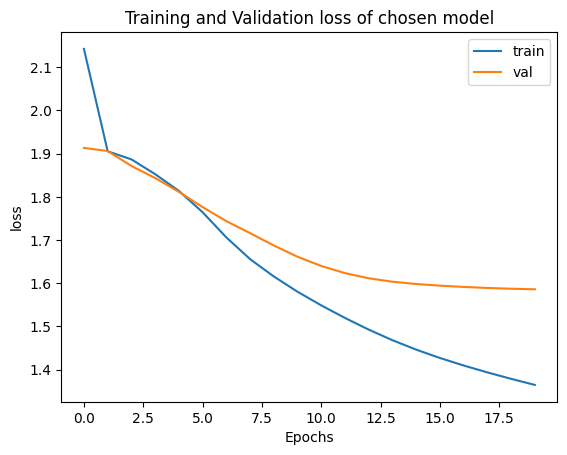

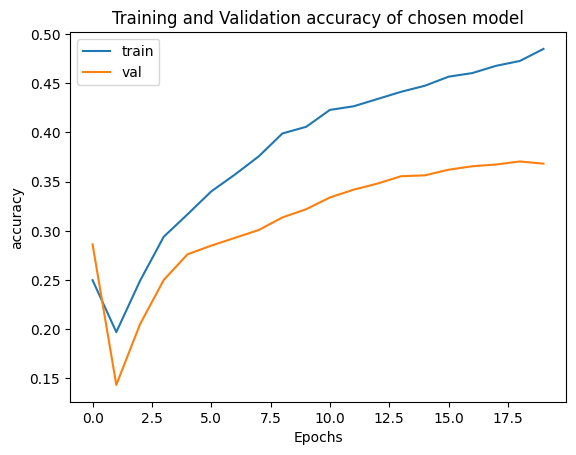

In [10]:
plot_performance_over_time(train_losses[chosen_index], val_losses[chosen_index], "Training and Validation loss of chosen model", "loss")
plot_performance_over_time(train_accs[chosen_index], val_accs[chosen_index], "Training and Validation accuracy of chosen model", "accuracy")

In [11]:
test_loader = DataLoader(data_test, batch_size=batch_size)

In [12]:
test_acc = compute_accuracy(chosen_model, train_loader, device=DEVICE)
print(test_acc)

0.4849600982197667
